# Citibike EDA

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

## Daily ride volume

In [2]:
# read pickled dataframe
citibike_df = pd.read_pickle('data/citibike_df_preprocessed.pkl')

In [3]:
# drop some columns and reset index
citibike_df = citibike_df.drop(['replace_zeroes'], axis=1)
citibike_df = citibike_df.reset_index(drop=True)
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,27


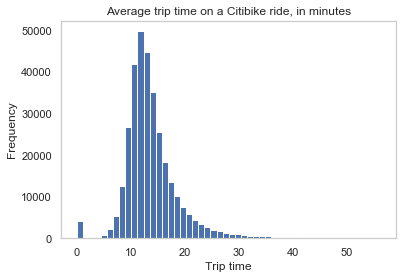

In [11]:
# plot distribution of average ride time in minutes
percentile_99 = np.percentile(citibike_df.mean_duration/60.0, 99)
plt.hist(citibike_df[citibike_df.mean_duration/60.0 < percentile_99].mean_duration/60.0, bins=50)
plt.title('Average trip time on a Citibike ride, in minutes')
plt.xlabel('Trip time')
plt.ylabel('Frequency');

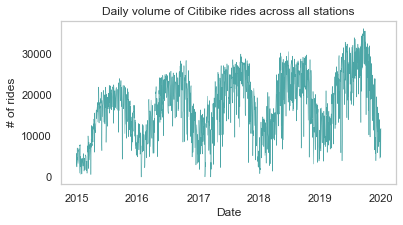

In [15]:
# total volume of citibike rides over time

fig = plt.figure(figsize=(6,3));
ax = fig.add_subplot(1, 1, 1)

plt.plot(citibike_df.groupby(['date']).agg({'ride_counts':'sum'}), color='teal', alpha=0.7, linewidth=0.5)

ax = plt.gca()

plt.title('Daily volume of Citibike rides across all stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

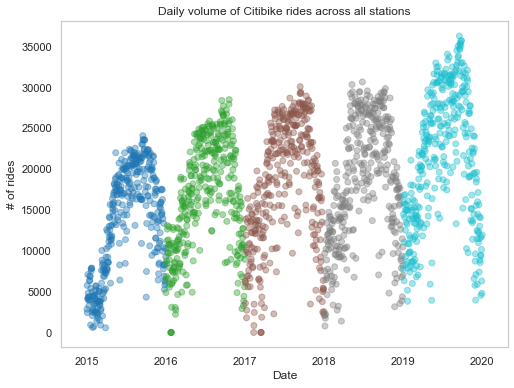

In [14]:
# total volume of citibike rides over time

fig = plt.figure(figsize=(8,6));
ax = fig.add_subplot(1, 1, 1) 

plt.scatter(citibike_df.groupby(['date']).agg({'ride_counts':'sum'}).reset_index().date,
            citibike_df.groupby(['date']).agg({'ride_counts':'sum'}).reset_index().ride_counts, c=citibike_df.groupby(['date']).agg({'ride_counts':'sum'}).reset_index().date.dt.year*1.0, cmap='tab10', alpha=0.4, linewidth=1.0)

ax = plt.gca()

plt.title('Daily volume of Citibike rides across all stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

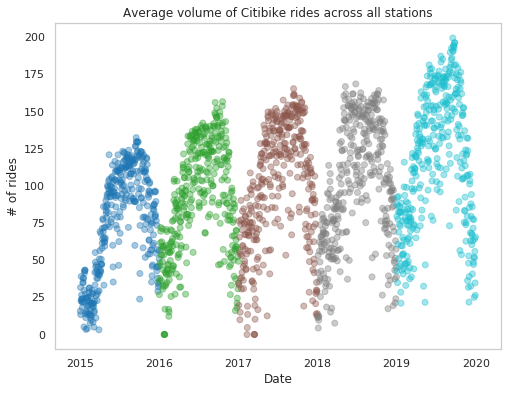

In [107]:
# average volume of citibike rides through time

fig = plt.figure(figsize=(8,6));
ax = fig.add_subplot(1, 1, 1) 

plt.scatter(citibike_df.groupby(['date']).agg({'ride_counts':'mean'}).reset_index().date,
            citibike_df.groupby(['date']).agg({'ride_counts':'mean'}).reset_index().ride_counts, c=citibike_df.groupby(['date']).agg({'ride_counts':'mean'}).reset_index().date.dt.year*1.0, cmap='tab10', alpha=0.4, linewidth=1.0)

ax = plt.gca()

plt.title('Average volume of Citibike rides across all stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

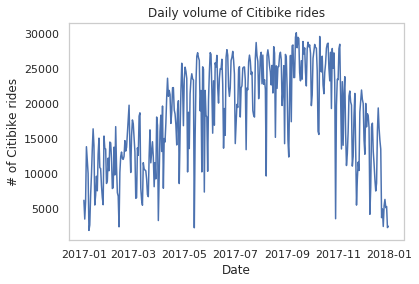

In [8]:
# plot daily ride counts across all stations for a particular year
plt.plot(citibike_df[citibike_df.year == 2017].groupby(['date']).agg({'ride_counts_clean':'sum'}))
plt.title('Daily volume of Citibike rides')
plt.xlabel('Date')
plt.ylabel('# of Citibike rides');

### By bike station

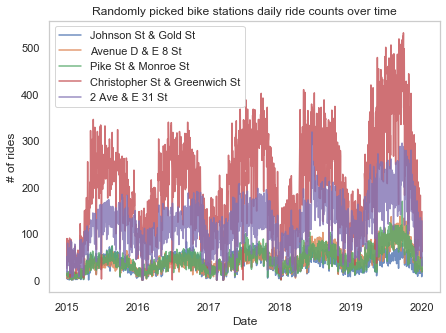

In [268]:
# randomly picked bike stations daily ride counts over time

fig = plt.figure(figsize=(7,5));
ax = fig.add_subplot(1, 1, 1) 

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=5, random_state=87)),] 

for i in sample_df.station_name.unique():
    plt.plot(sample_df.loc[sample_df.station_name == i].date,
             sample_df.loc[sample_df.station_name == i].ride_counts, 
             alpha=0.8, linewidth=1.5)
    
ax = plt.gca()

plt.title('Randomly picked bike stations daily ride counts over time')
plt.xlabel('Date')
plt.ylabel('# of rides')
plt.legend([i for i in sample_df.station_name.unique()]);

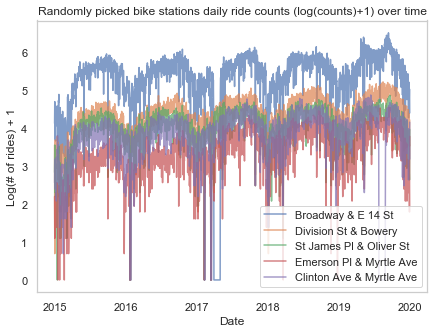

In [283]:
# randomly picked bike stations daily ride counts (log+1) over time

fig = plt.figure(figsize=(7,5));
ax = fig.add_subplot(1, 1, 1) 

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=5, random_state=60)),] 

for i in sample_df.station_name.unique():
    plt.plot(sample_df.loc[sample_df.station_name == i].date,
             np.log1p(sample_df.loc[sample_df.station_name == i].ride_counts), 
             alpha=0.7, linewidth=1.5)
    
ax = plt.gca()

plt.title('Randomly picked bike stations daily ride counts (log(counts)+1) over time')
plt.xlabel('Date')
plt.ylabel('Log(# of rides) + 1')
plt.legend([i for i in sample_df.station_name.unique()]);

In [18]:
# top stations in terms of daily average volume of bike rides in 2019
citibike_df[(citibike_df.year == 2019)].groupby(['station_id', 'station_name'])['ride_counts_clean'].mean().round(1).sort_values(ascending=False).head(20)

station_id  station_name                     
519         Pershing Square North                429.0
497         E 17 St & Broadway                   333.6
435         W 21 St & 6 Ave                      318.6
402         Broadway & E 22 St                   310.8
285         Broadway & E 14 St                   309.6
426         West St & Chambers St                289.4
499         Broadway & W 60 St                   282.6
358         Christopher St & Greenwich St        277.8
514         12 Ave & W 40 St                     272.1
459         W 20 St & 11 Ave                     265.7
379         W 31 St & 7 Ave                      236.7
151         Cleveland Pl & Spring St             233.1
491         E 24 St & Park Ave S                 231.0
359         E 47 St & Park Ave                   227.1
504         1 Ave & E 15 St                      226.2
492         W 33 St & 7 Ave                      225.2
281         Grand Army Plaza & Central Park S    220.6
168         W 18 St

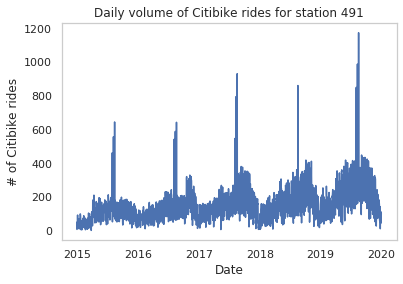

In [62]:
# plot daily ride counts for E 24 St & Park Ave S station
plt.plot(citibike_df[citibike_df.station_id == 491].date,
         citibike_df[citibike_df.station_id == 491].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 491')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

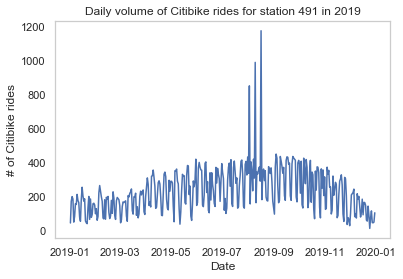

In [8]:
# plot daily ride counts in 2019 for E 24 St & Park Ave S station
plt.plot(citibike_df[(citibike_df.station_id == 491) & (citibike_df.year == 2019)].date,
         citibike_df[(citibike_df.station_id == 491) & (citibike_df.year == 2019)].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 491 in 2019')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

In [101]:
# inspect the outliers for station at E 24 St & Park Ave S
citibike_df[(citibike_df.station_id == 491) & 
            (citibike_df.year == 2017) & 
            (citibike_df.month > 7) &  
            (citibike_df.month < 9) &
            (citibike_df.ride_counts_clean > 400)]

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts_clean
384407,2017-08-05,491,E 24 St & Park Ave S,40.740964,-73.986022,1698.895795,2017,8,5,547
384414,2017-08-12,491,E 24 St & Park Ave S,40.740964,-73.986022,1606.586164,2017,8,5,795
384421,2017-08-19,491,E 24 St & Park Ave S,40.740964,-73.986022,1388.678840,2017,8,5,931


## Monthly ride volume

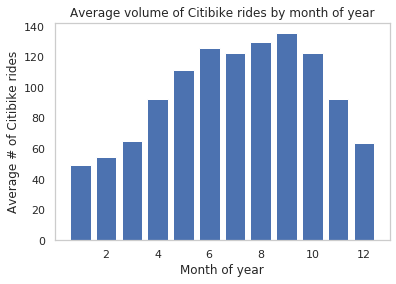

In [209]:
# average volume of citibike rides by month of year
citibike_monthly = citibike_df.groupby(['month'])['ride_counts_clean'].mean().reset_index()
plt.bar(np.array(citibike_monthly.month), np.array(citibike_monthly.ride_counts_clean))
plt.title('Average volume of Citibike rides by month of year')
plt.xlabel('Month of year')
plt.ylabel('Average # of Citibike rides');

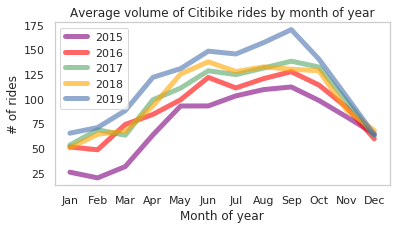

In [47]:
# average volume of citibike rides by month of year
citibike_monthly = citibike_df.groupby(['month','year'])['ride_counts_clean'].mean().reset_index()

fig = plt.figure(figsize=(6,3));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2015].ride_counts_clean), color='purple', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2016].ride_counts_clean), color='red', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2017].ride_counts_clean), color='g', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2018].ride_counts_clean), color='orange', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2019].ride_counts_clean), color='b', alpha=0.6, linewidth=5.0)


ax = plt.gca()

plt.title('Average volume of Citibike rides by month of year')
plt.xlabel('Month of year')
plt.ylabel('# of rides')
plt.legend(['2015', '2016', '2017', '2018', '2019']);

## Day of week ride volume

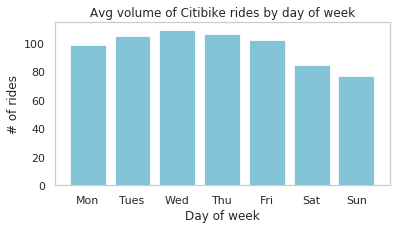

In [46]:
# average volume of citibike rides by day of week

citibike_daily = citibike_df.groupby(['day_of_week'])['ride_counts_clean'].mean().reset_index()

fig = plt.figure(figsize=(6,3));
ax = fig.add_subplot(1, 1, 1) 

plt.bar(np.array(['Mon','Tues','Wed','Thu','Fri','Sat','Sun']), np.array(citibike_daily.ride_counts_clean), color='c', alpha=0.8)

ax = plt.gca()

plt.title('Avg volume of Citibike rides by day of week')
plt.xlabel('Day of week')
plt.ylabel('# of rides');

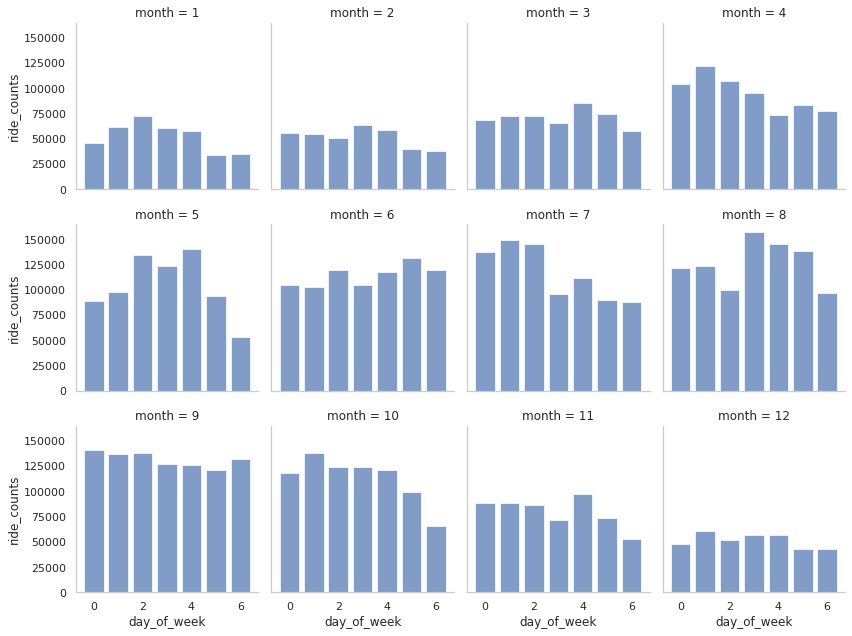

In [138]:
# total volume by day of week and month of year

citibike_day_month = citibike_df[citibike_df.year == 2019].groupby(['day_of_week','month'])['ride_counts'].sum().reset_index()

g = sns.FacetGrid(citibike_day_month, col="month", col_wrap=4) #  row="month")
g = g.map(plt.bar, "day_of_week", "ride_counts", color='b', alpha=0.7)